In [27]:
##### Investigate why LOOCV performs worse on clinics with a high prevalence of CIP R
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import os 
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')


In [28]:
############# data

#nn_data 

best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_hyperparameters_by_year_rf ={2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}
best_hyperparameters_by_year_nn ={2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
best_features_by_year_rf ={2005: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'West', 'PREV_REGION', 'DELTA_REGION', 'Oth/Unk/Missing', 'MSMW'], 2006: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'MSMW', 'Northeast', 'Southeast', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Southeast', 'MSMW', 'Northeast'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'West', 'Northeast', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'DELTA_REGION', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'DELTA_REGION', 'Oth/Unk/Missing', 'West', 'Northeast', 'Southeast'], 2010: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'Oth/Unk/Missing', 'West', 'Southeast', 'MSMW', 'DELTA_REGION', 'Northeast']}
best_features_by_year_nn ={2005: ['MSM', 'DELTA_CLINIC', 'MSW', 'Southwest', 'MSMW', 'DELTA_REGION', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'Southwest', 'MSMW'], 2008: ['MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'Southeast', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southwest', 'West', 'Northeast'], 2010: ['MSM', 'MSW', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Southeast', 'MSMW', 'Southwest', 'Oth/Unk/Missing', 'Northeast', 'West']}
ROC_by_year_lr = {2005: 0.7322853685805495, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6968498187602681, 2009: 0.639172181709682, 2010: 0.6797716960932587}
ROC_by_year_rf ={2005: 0.7586099894081821, 2006: 0.7418094620985698, 2007: 0.7033306886765269, 2008: 0.6939654992567867, 2009: 0.679491422061069, 2010: 0.6840913725423555}
ROC_by_year_nn ={2005: 0.7372748012808253, 2006: 0.7324350027761852, 2007: 0.6936770334581981, 2008: 0.7043116801835867, 2009: 0.6705138326697341, 2010: 0.6835202587500921}


In [6]:
### Get proportion MSM for each year 

i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
clinics_above_average_prevalnce_all = {}
clinics_above_MSM_all = {}
clinics_below_MSM_all = {}
clinics_above_MSW_all = {}
clinics_below_MSW_all = {}
for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    model_type = 1
    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names =best_features_by_year_rf[year], years_train = years_train, model_type = model_type)

    clinics = CIP_data_testing_years["CLINIC"].unique()
    clinics_above_average_prevalence = []
    test_data_MSM_above = []
    test_data_MSM_below = []    
    test_data_MSW_above = []
    test_data_MSW_below = [] 
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_rf[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_rf[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
            clinics_above_average_prevalence.append(clinic)
            test_data_MSM_above.append(test_data["MSM"].sum()/len(test_data["MSM"]))
            test_data_MSW_above.append(test_data["MSW"].sum()/len(test_data["MSW"]))

          else:
            test_data_MSM_below.append(test_data["MSM"].sum()/len(test_data["MSM"]))
            test_data_MSW_below.append(test_data["MSW"].sum()/len(test_data["MSW"]))

    clinics_above_average_prevalnce_all.__setitem__(year,clinics_above_average_prevalence)
    clinics_above_MSM_all.__setitem__(year, test_data_MSM_above)
    clinics_below_MSM_all.__setitem__(year, test_data_MSM_below)
    clinics_above_MSW_all.__setitem__(year, test_data_MSW_above)
    clinics_below_MSW_all.__setitem__(year, test_data_MSW_below)



Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


In [29]:
year = 2010
print(clinics_above_average_prevalnce_all[year])
print(clinics_above_MSM_all[year])
print(clinics_below_MSM_all[year])


['ALB', 'CHI', 'DEN', 'HON', 'LAX', 'MIA', 'MIN', 'NOR', 'NYC', 'ORA', 'PHI', 'PHX', 'POR', 'SDG', 'SEA', 'SFO']
[0.26666666666666666, 0.36, 0.2384937238493724, 0.358974358974359, 0.6477272727272727, 0.19617224880382775, 0.4647887323943662, 0.102880658436214, 0.18686868686868688, 0.5192307692307693, 0.12837837837837837, 0.35678391959798994, 0.6226415094339622, 0.8097560975609757, 0.6386554621848739, 0.591304347826087]
[0.14634146341463414, 0.05737704918032787, 0.03007518796992481, 0.031088082901554404, 0.0660377358490566, 0.11824324324324324, 0.04081632653061224, 0.042328042328042326, 0.04666666666666667, 0.18, 0.055793991416309016, 0.14285714285714285]


In [ ]:
## what if I add a fature to the dataset that is the proportion of MSM in each clinic? 




In [87]:
## Import modules 

import pandas as pd
from sklearn import preprocessing
from Functions_AMR_gonorrhea import encoder_for_GISP
from sklearn.preprocessing import OneHotEncoder


def encoder_for_GISP(data, column):
    encoder = OneHotEncoder()
    encoder_categories = encoder.fit(data[[column]]).categories_
    encoder_categories = encoder_categories[0].tolist()
    encoder_df = pd.DataFrame(encoder.fit_transform(data[[column]]).toarray())
    combined_data = data.join(encoder_df)
    col_names = list(data.columns) + encoder_categories[0:]
    combined_data.columns = col_names
    return combined_data

## read data 
CIP_data = pd.read_csv("CIP_Resistant_disagregated.csv")



## Categories for location of clinic
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

### Add "Region" column
CIP_data['REGION'] = CIP_data['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) 

## One-hot encoding 
CIP_data_encoded_gend_region = encoder_for_GISP(CIP_data, 'GENDERSP')
CIP_data_encoded_gend_region = encoder_for_GISP(CIP_data_encoded_gend_region, 'REGION')

## Prevalence by region and clinic
regions = CIP_data_encoded_gend_region["REGION"].unique()
years = CIP_data_encoded_gend_region["YEAR"].unique()
for year in years:
    CIP_data_year = CIP_data_encoded_gend_region.loc[CIP_data_encoded_gend_region['YEAR'] == year]
    suscep_by_region = (CIP_data_year.groupby(by = ["REGION"])["Susceptible"].sum())
    suscep_by_clinic = (CIP_data_year.groupby(by = ["CLINIC"])["Susceptible"].sum())
    clinics = CIP_data_year["CLINIC"].unique() ## each year surveyed different clinics
    prevalence_by_clinic = {}
    prevalence_by_region = {}
    for region in regions:
            prevalence_by_region[region] = 1 - suscep_by_region[region]/len(CIP_data_year[CIP_data_year.REGION == region])
            if year == 2000:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2000) & (CIP_data_encoded_gend_region["REGION"] == region), "PREV_REGION"] = 0
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2001) & (CIP_data_encoded_gend_region["REGION"] == region), "PREV_REGION"] = prevalence_by_region[region]

            else:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == year + 1) & (CIP_data_encoded_gend_region["REGION"] == region), "PREV_REGION"] = prevalence_by_region[region] ### Add 1 to enter in next year's prevalence

    for clinic in clinics:
            prevalence_by_clinic[clinic] = 1 - suscep_by_clinic[clinic]/len(CIP_data_year[CIP_data_year.CLINIC == clinic])
            if year == 2000:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2000) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "PREV_CLINIC"] = 0
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2001) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "PREV_CLINIC"] = prevalence_by_clinic[clinic]

            else:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == year + 1) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "PREV_CLINIC"] = prevalence_by_clinic[clinic]

CIP_data_encoded_gend_region["PREV_CLINIC"] = CIP_data_encoded_gend_region["PREV_CLINIC"].fillna(0) # gets rid of issues where previous year the clinic wasn't monitored


## Change in prevalence by region and clinic 

for year in years:
    CIP_data_year = CIP_data_encoded_gend_region.loc[CIP_data_encoded_gend_region['YEAR'] == year]
    clinics = CIP_data_year["CLINIC"].unique()
    suscep_by_clinic_current = (CIP_data_year.groupby(by = ["CLINIC"])["Susceptible"].sum())
    suscep_by_region_current = (CIP_data_year.groupby(by = ["REGION"])["Susceptible"].sum())

    prevalence_by_clinic_current = {}
    prevalence_by_region_current = {}

    for region in regions:
            prevalence_by_region_current[region] = 1 - suscep_by_region_current[region]/len(CIP_data_year[CIP_data_year.REGION == region])
            if year == 2000:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2000) & (CIP_data_encoded_gend_region["REGION"] == region), "DELTA_REGION"] = 0
                #CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2001) & (CIP_data_encoded_gend_region["REGION"] == region), "DELTA_REGION"] = prevalence_by_region_current[region]

            else:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == year) & (CIP_data_encoded_gend_region["REGION"] == region), "DELTA_REGION"] = prevalence_by_region_current[region] - prevalence_by_region_previous[region]
    for clinic in clinics:
            prevalence_by_clinic_current[clinic] = 1 - suscep_by_clinic_current[clinic]/len(CIP_data_year[CIP_data_year.CLINIC == clinic])
            if year == 2000:
                CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == 2000) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "DELTA_CLINIC"] = 0

            else:
                try: 
                    CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == year) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "DELTA_CLINIC"] = prevalence_by_clinic_current[clinic] - prevalence_by_clinic_previous[clinic]
                except KeyError:
                     CIP_data_encoded_gend_region.loc[(CIP_data_encoded_gend_region["YEAR"] == year) & (CIP_data_encoded_gend_region["CLINIC"] == clinic), "DELTA_CLINIC"] = 0
    
    prevalence_by_region_previous = prevalence_by_region_current

    prevalence_by_clinic_previous = prevalence_by_clinic_current

## Proportion of AMR that are in the MSM group and change each year
years = CIP_data_no_drop["YEAR"].unique()
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    MSM_by_clinic = (CIP_data_year.groupby(by = ["CLINIC"])["MSM"].sum())

    clinics = CIP_data_year["CLINIC"].unique() ## each year surveyed different clinics
    Proportion_MSM_by_clinic = {}
    for clinic in clinics:

            Proportion_MSM_by_clinic[clinic] = 1 - MSM_by_clinic[clinic]/len(CIP_data_year[CIP_data_year.CLINIC == clinic])
            CIP_data_no_drop.loc[(CIP_data_no_drop["YEAR"] == year) & (CIP_data_no_drop["CLINIC"] == clinic), "MSM_CLINIC"] = Proportion_MSM_by_clinic[clinic]
            if year == 2000:
                CIP_data_no_drop.loc[(CIP_data_no_drop["YEAR"] == 2000) & (CIP_data_no_drop["CLINIC"] == clinic), "DELTA_MSM_CLINIC"] = 0

            else:
                try: 
                    CIP_data_no_drop.loc[(CIP_data_no_drop["YEAR"] == year) & (CIP_data_no_drop["CLINIC"] == clinic), "DELTA_MSM_CLINIC"] = Proportion_MSM_by_clinic[clinic] - Proportion_MSM_by_clinic_previous[clinic]
                except KeyError:
                     CIP_data_no_drop.loc[(CIP_data_no_drop["YEAR"] == year) & (CIP_data_no_drop["CLINIC"] == clinic), "DELTA_MSM_CLINIC"] = 0
    
            Proportion_MSM_by_clinic_previous = Proportion_MSM_by_clinic

In [88]:
from sklearn import preprocessing


X_train_continuous = CIP_data_no_drop[["PREV_REGION", "PREV_REGION", "DELTA_REGION", "DELTA_CLINIC", "MSM_CLINIC", "DELTA_MSM_CLINIC"]]
scaler = preprocessing.StandardScaler().fit(X_train_continuous)
CIP_data_no_drop[["PREV_REGION", "PREV_REGION", "DELTA_REGION", "DELTA_CLINIC", "MSM_CLINIC", "DELTA_MSM_CLINIC"]] = scaler.transform(X_train_continuous)

In [33]:
CIP_data_no_drop.head

<bound method NDFrame.head of         Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0                  0             0             0             0           0   
1                  1             1             1             1           0   
2                  2             2             2             2           0   
3                  3             3             3             3           0   
4                  4             4             4             4           0   
...              ...           ...           ...           ...         ...   
112482        112482        112482        112482        112482        1968   
112483        112483        112483        112483        112483        1968   
112484        112484        112484        112484        112484        1968   
112485        112485        112485        112485        112485        1968   
112486        112486        112486        112486        112486        1969   

       CLINIC  YEAR         GENDE

In [ ]:
### Try neural network LOOCV except add in MSM_CLINIC as an important feature

In [34]:
############# data

#nn_data 

best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_hyperparameters_by_year_rf ={2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}
best_hyperparameters_by_year_nn ={2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}
best_features_by_year_lr = {2005: ['MSM_CLINIC', 'PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['MSM_CLINIC', 'DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSM_CLINIC', 'MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['MSM_CLINIC', 'PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['MSM_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSM_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
best_features_by_year_rf ={2005: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'West', 'PREV_REGION', 'DELTA_REGION', 'Oth/Unk/Missing', 'MSMW'], 2006: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'MSMW', 'Northeast', 'Southeast', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Southeast', 'MSMW', 'Northeast'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'West', 'Northeast', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'DELTA_REGION', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'DELTA_REGION', 'Oth/Unk/Missing', 'West', 'Northeast', 'Southeast'], 2010: ['MSW', 'DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'Oth/Unk/Missing', 'West', 'Southeast', 'MSMW', 'DELTA_REGION', 'Northeast']}
best_features_by_year_nn ={2005: ['MSM', 'DELTA_CLINIC', 'MSW', 'Southwest', 'MSMW', 'DELTA_REGION', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSM', 'PREV_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'Southwest', 'MSMW'], 2008: ['MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'Southeast', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southwest', 'West', 'Northeast'], 2010: ['MSM', 'MSW', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Southeast', 'MSMW', 'Southwest', 'Oth/Unk/Missing', 'Northeast', 'West']}
ROC_by_year_lr = {2005: 0.7322853685805495, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6968498187602681, 2009: 0.639172181709682, 2010: 0.6797716960932587}
ROC_by_year_rf ={2005: 0.7586099894081821, 2006: 0.7418094620985698, 2007: 0.7033306886765269, 2008: 0.6939654992567867, 2009: 0.679491422061069, 2010: 0.6840913725423555}
ROC_by_year_nn ={2005: 0.7372748012808253, 2006: 0.7324350027761852, 2007: 0.6936770334581981, 2008: 0.7043116801835867, 2009: 0.6705138326697341, 2010: 0.6835202587500921}


In [72]:
################################ Get hyperparameters and best features for each model with MSM CLINIC  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=20,random_state=1) ## 10-fold cross validations
# logistic regression 
space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}
# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'MSM_CLINIC', "DELTA_MSM_CLINIC"]
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


In [89]:
## Parameters and features for  Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
best_hyperparameters1 = {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.74}
i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    #best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    #imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model
    #imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 
    print("Hyperparameters2")


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2
2006
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2
2007
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2
2008
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2
2009
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2
2010
Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4800 fits failed out of a total of 20000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2800 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3

Hyperparameters2


In [51]:
print(best_features_by_year[model_type])
print({2005: ['MSM_CLINIC', 'PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['MSM_CLINIC', 'DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSM_CLINIC', 'MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['MSM_CLINIC', 'PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['MSM_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSM_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'PREV_REGION', 'Northeast']}
)

{2005: ['MSW', 'PREV_CLINIC', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'Southwest', 'MSM', 'Southeast'], 2007: ['MSW', 'PREV_CLINIC', 'Oth/Unk/Missing', 'Southwest'], 2008: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM_CLINIC', 'MSM', 'Oth/Unk/Missing', 'West', 'Southeast', 'Southwest'], 2009: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSM_CLINIC', 'MSW', 'West', 'DELTA_REGION', 'Oth/Unk/Missing', 'Southeast'], 2010: ['DELTA_CLINIC', 'MSW', 'PREV_CLINIC', 'MSM_CLINIC', 'Oth/Unk/Missing', 'MSM', 'Northeast', 'PREV_REGION']}
{2005: ['MSM_CLINIC', 'PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'PREV_REGION', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2006: ['MSM_CLINIC', 'DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSM_CLINIC', 'MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing'], 2008: ['MSM_CLINIC', 'PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_R

In [90]:
best_hyperparameters_by_year_lr =  best_hyperparameters_by_year[model_type]
best_features_by_year_lr = best_features_by_year[model_type]

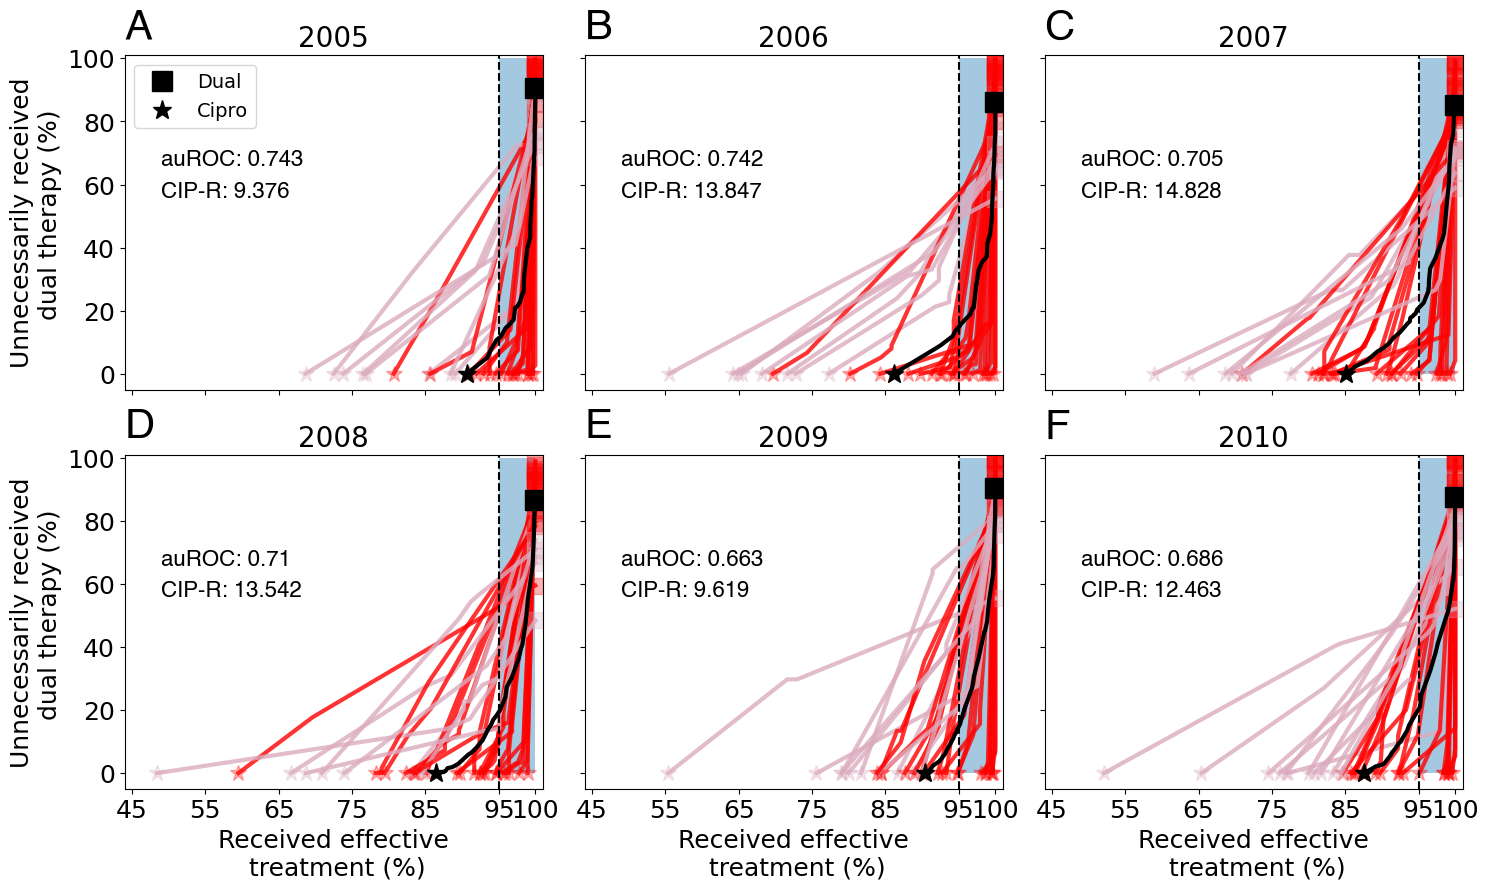

In [91]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n  dual therapy (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  dual therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
average_number_observations_by_year = []
for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year],years_train = years_train, model_type = 0)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    number_observations = []

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_lr[year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_lr[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)
        number_observations.append(len(test_data))
        if cipro_R > 0: 
          try:
          # test 
            
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              if test_data["MSM"].sum()/len(test_data["MSM"]) < .250:
                 col = "red"
                 alpha_graph = 0.8
              #if len(test_data) > 200 :
                 #col = "green"

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    average_number_observations_by_year.append(np.mean(number_observations))
    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)

plt.tight_layout()

In [69]:
average_number_observations_by_year

[238.34615384615384,
 225.4814814814815,
 207.20689655172413,
 204.39285714285714,
 200.85714285714286,
 203.17857142857142]

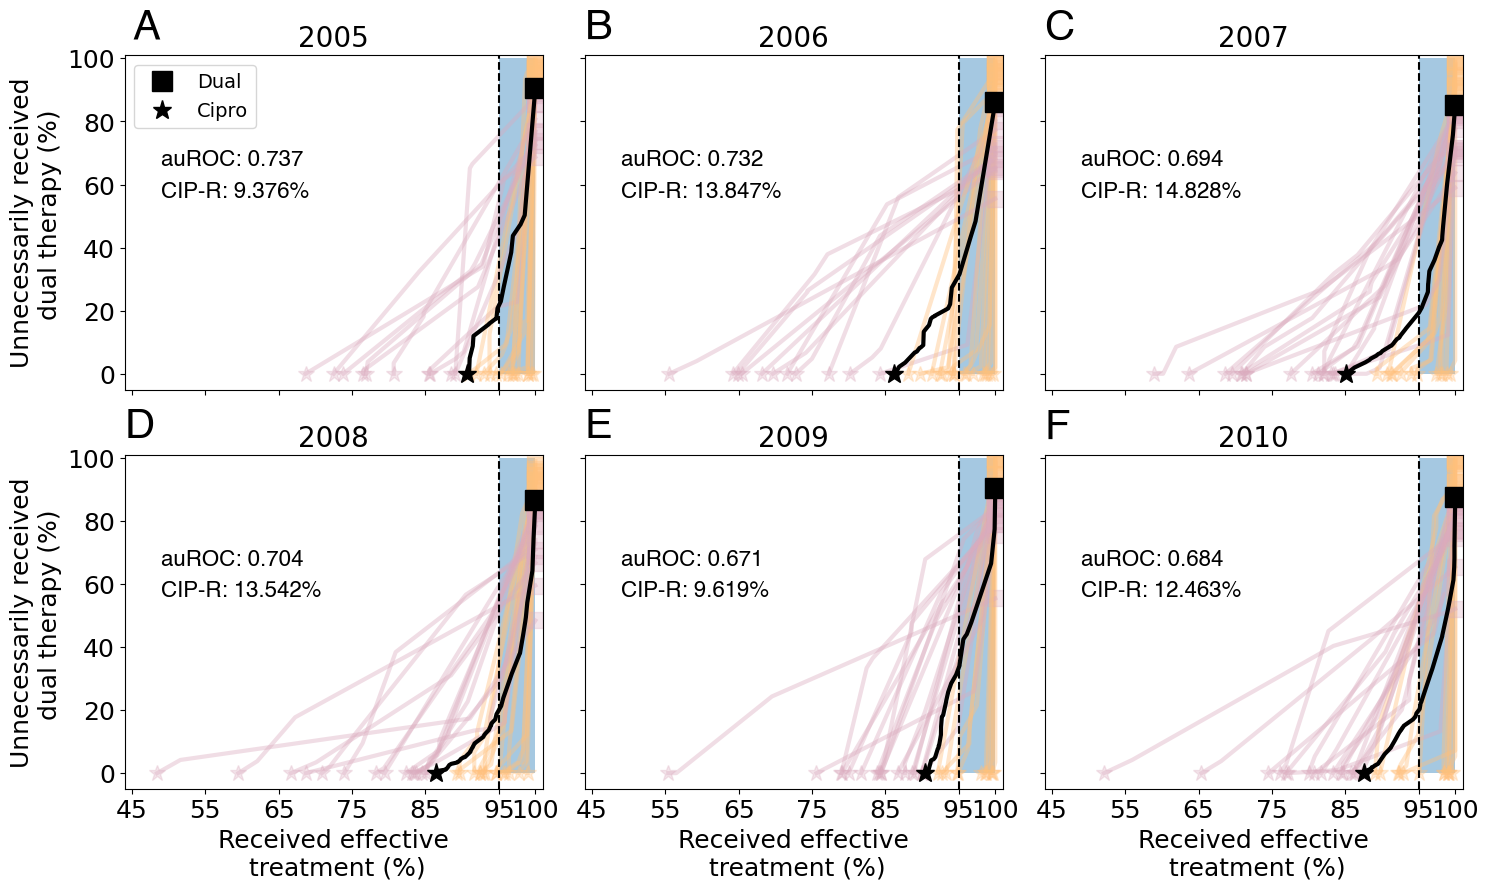

In [12]:
### Leave one out validation for MLP 
from matplotlib.patches import Polygon
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
labels = ["A", "B", "C", "D", "E", "F" ]

polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
threshold_seq = np.linspace(0,1,101)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  dual therapy (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  dual therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
#test_years = [2005]
axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([45, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year],years_train = years_train, model_type = 0)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[ best_features_by_year_nn[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[ best_features_by_year_nn[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.4
          else:
              col = '#ffc07c'
              alpha_graph = 0.4
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
          
          except ValueError:
            #try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=1)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              #y_test.astype(y_predict_test.dtype)
              sensitivity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
   


            #except ValueError:
              #print('x')
              #pass
    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")
    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_nn[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    #for index in indices:
    #    axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
    axs[i].set_title(year,fontsize=20)

    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()

In [22]:
## Just NN
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=337, learning_rate = 'adaptive' )

space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 1000)
space['learning_rate'] = ['constant', 'adaptive']

space['hidden_layer_sizes'] = [(8,), (9,), (10,), (11,), (12,), (13,), (14,)]
#space['solver'] = ['lbfgs', 'sgd', 'adam']
space['solver'] = ['adam']

i = 0
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
    
     
    ## fit model w/hyperparameters 
    model_fit = model_nn.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    #imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model
    #imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_nn = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])

    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
Oversample


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training 

KeyboardInterrupt: 

In [59]:
### What about the number of samples in each year? 

### Get proportion MSM for each year 

i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
clinics_above_average_prevalnce_all = {}
clinics_above_obs_all = {}
clinics_below_obs_all = {}

for year in years: 
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    model_type = 1
    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names =best_features_by_year_lr[year], years_train = years_train, model_type = model_type)

    clinics = CIP_data_testing_years["CLINIC"].unique()
    clinics_above_average_prevalence = []
    test_data_obs_above = []
    test_data_obs_below = []    

    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_lr[year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_lr[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
            clinics_above_average_prevalence.append(clinic)
            test_data_obs_above.append(len(test_data))

          else:
            test_data_obs_below.append(len(test_data))

    clinics_above_average_prevalnce_all.__setitem__(year,clinics_above_average_prevalence)
    clinics_above_obs_all.__setitem__(year, test_data_obs_above)
    clinics_below_obs_all.__setitem__(year, test_data_obs_below)



Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


In [61]:
print(clinics_above_average_prevalnce_all)
print(clinics_above_obs_all)
print(clinics_below_obs_all)

{2005: ['DEN', 'HON', 'LAX', 'LBC', 'ORA', 'PHI', 'POR', 'SDG', 'SEA', 'SFO'], 2006: ['DEN', 'HON', 'LAX', 'LBC', 'MIA', 'ORA', 'PHI', 'POR', 'SDG', 'SEA', 'SFO'], 2007: ['ALB', 'DEN', 'HON', 'KCY', 'LAX', 'LBC', 'LVG', 'MIA', 'NOR', 'NYC', 'ORA', 'PHI', 'POR', 'RIC', 'SDG', 'SEA', 'SFO'], 2008: ['HON', 'LAX', 'LVG', 'MIA', 'NOR', 'NYC', 'ORA', 'PHI', 'PHX', 'POR', 'RIC', 'SDG', 'SEA', 'SFO'], 2009: ['BHM', 'CHI', 'DEN', 'HON', 'LAX', 'LVG', 'MIA', 'MIN', 'NYC', 'ORA', 'PHI', 'PHX', 'POR', 'RIC', 'SDG', 'SEA', 'SFO'], 2010: ['ALB', 'CHI', 'DEN', 'HON', 'LAX', 'MIA', 'MIN', 'NOR', 'NYC', 'ORA', 'PHI', 'PHX', 'POR', 'SDG', 'SEA', 'SFO']}
{2005: [284, 88, 193, 98, 120, 300, 238, 294, 268, 300], 2006: [293, 95, 207, 67, 212, 133, 300, 169, 262, 242, 299], 2007: [156, 218, 70, 55, 165, 69, 300, 266, 249, 181, 117, 282, 147, 28, 190, 188, 300], 2008: [79, 125, 300, 259, 175, 123, 87, 253, 248, 157, 124, 182, 163, 211], 2009: [209, 235, 230, 74, 210, 300, 219, 123, 179, 82, 206, 227, 105, 31,